#  Gene Sets and Expression for Tumor vs. Normal and Tissue Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [85]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

# fix random seed for reproducibility
np.random.seed(42)

In [86]:
%%time
# Load samples and labels
X = pd.read_hdf("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5", "expression")
print("X: samples={} genes={}".format(*X.shape))

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", header=0,
                      names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                      sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str")
print("Y: samples={} labels={}".format(*Y.shape))

X: samples=19249 genes=58581
Y: samples=19131 labels=6
CPU times: user 548 ms, sys: 2.83 s, total: 3.38 s
Wall time: 3.38 s


In [87]:
# Sort so indexes match
X.sort_index(axis=0, inplace=True)
X.sort_index(axis=1, inplace=True)
Y.sort_index(axis=0, inplace=True)

# Remove rows where the class is null or the sample is missing
intersection = X.index.intersection(Y[pd.notnull(Y["primary_site"])].index)
X = X[X.index.isin(intersection)]
Y = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X.index.equals(Y.index))

print(intersection.shape[0], "samples with non-null labels")

19115 samples with non-null labels


In [88]:
# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y.loc[:, "tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

# Convert tumor_normal and primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)
Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
count,19115,19115,19115,19115,18957,19115,19115,19115.000000,19115.000000
unique,93,93,46,16,2,3,2,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN
freq,1212,1212,1835,9185,10447,10534,10530,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550876,20.659273
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497418,12.419497
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000


In [89]:
X[0:20000:3000].head()

sample,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,0.0,0.0,0.0,7.3524,6.1269,1.9343,14.432300,6.5937,4.6431,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-145LS-1226-SM-5Q5D9,0.0,0.0,0.0,6.4274,6.8759,1.0336,18.091999,6.6323,2.0501,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-X8HC-0126-SM-4E3JW,0.0,0.0,0.0,7.1905,7.3925,1.8230,13.508500,4.3042,11.9234,1.823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1821,0.0000
TCGA-24-1436-01,0.0,0.0,0.0,7.8777,8.3273,0.0000,14.739500,6.5108,5.7128,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.6946
TCGA-BG-A3PP-01,0.0,0.0,0.0,5.4354,5.4573,0.0000,13.103800,5.9861,7.4694,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000


In [90]:
Y[0:20000:3000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal,0,0
GTEX-145LS-1226-SM-5Q5D9,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22
GTEX-X8HC-0126-SM-4E3JW,Skin - Sun Exposed (Lower Leg),Skin - Sun Exposed (Lower Leg),Skin,Normal Tissue,Female,GTEX,Normal,0,33
TCGA-24-1436-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,Tumor,1,26
TCGA-BG-A3PP-01,Uterine Corpus Endometrioid Carcinoma,Uterine Corpus Endometrioid Carcinoma,Endometrium,Primary Tumor,Female,TCGA,Tumor,1,13


In [171]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any that are not in X
gene_sets = {name: sorted([gene for gene in genes if gene in X_pruned.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X of any genes not in our gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19115, 5172)


In [162]:
# Create a multi-class one hot output with primary site + tumor/normal
from keras.utils import np_utils
primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
tumor_normal_one_hot = Y["tumor_normal_value"]
Y_multiclass_onehot = np.append(primary_site_one_hot, tumor_normal_one_hot.values.reshape(
    tumor_normal_one_hot.shape[0],-1), axis=1)
print(Y_multiclass_onehot.shape)
print(Y_multiclass_onehot)

(19115, 47)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [129]:
# Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
# proportions of each tissue type in the train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["tumor_normal_value"]):
    X_train, X_test = X_pruned.values[train_index], X_pruned.values[test_index]
    y_train, y_test = Y_multiclass_onehot[train_index], Y_multiclass_onehot[test_index]
    classes_train, classes_test = Y["primary_site_value"].values[train_index], Y["primary_site_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15292, 5172) (3823, 5172)


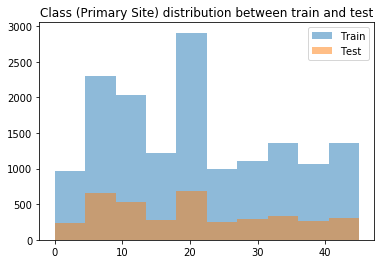

In [163]:
import matplotlib.pyplot as pyplot
pyplot.hist(classes_train, alpha=0.5, label='Train')
pyplot.hist(classes_test, alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Class (Primary Site) distribution between train and test")
pyplot.show()

In [172]:
# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

In [398]:
# Incantation that pulls the index of each gene out of the overall set of genes
np.searchsorted(X_pruned.columns.values, gene_sets["KEGG_ABC_TRANSPORTERS"])

array([  11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,  848, 4692, 4693])

In [405]:
"""
Build a model and train
"""
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Activation, Dropout, Concatenate
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K

import itertools

epochs=1
batch_size=128

main_input = Input(shape=(X_train.shape[1],), name="main_input")

# # Use only max_gene_sets and max_genes from each set
# max_gene_sets = 10
# max_genes = 10
# pathways = [
#     Dense(1, activation='relu', name=pathway)
#     (Lambda(lambda x: K.concatenate(
#         [x[:, i:i+1] for i in np.searchsorted(X_pruned.columns.values, genes)[0:max_genes]]))(main_input))
#     for pathway, genes in itertools.islice(gene_sets.items(), 0, max_gene_sets)]


pathways = [
    Dense(1, activation='relu', name=pathway)
    (Lambda(lambda x: K.concatenate(
        [x[:, i:i+1] for i in np.searchsorted(X_pruned.columns.values, genes)]))(main_input))
    for pathway, genes in gene_sets.items()]

x = keras.layers.concatenate(pathways)
x = Dense(20, activity_regularizer=regularizers.l1(1e-5), activation='relu')(x)
x = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=[main_input], outputs=[x])
print(model.summary())

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
# model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

# print(model.metrics_names, model.evaluate(X_test, y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 5172)         0                                            
__________________________________________________________________________________________________
lambda_551 (Lambda)             (None, 61)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_552 (Lambda)             (None, 30)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_553 (Lambda)             (None, 26)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_554

__________________________________________________________________________________________________
lambda_729 (Lambda)             (None, 135)          0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_730 (Lambda)             (None, 35)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_731 (Lambda)             (None, 37)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_732 (Lambda)             (None, 35)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_733 (Lambda)             (None, 83)           0           main_input[0][0]                 
__________

                                                                 KEGG_PYRIMIDINE_METABOLISM[0][0] 
                                                                 KEGG_ALANINE_ASPARTATE_AND_GLUTAM
                                                                 KEGG_GLYCINE_SERINE_AND_THREONINE
                                                                 KEGG_CYSTEINE_AND_METHIONINE_META
                                                                 KEGG_VALINE_LEUCINE_AND_ISOLEUCIN
                                                                 KEGG_VALINE_LEUCINE_AND_ISOLEUCIN
                                                                 KEGG_LYSINE_DEGRADATION[0][0]    
                                                                 KEGG_ARGININE_AND_PROLINE_METABOL
                                                                 KEGG_HISTIDINE_METABOLISM[0][0]  
                                                                 KEGG_TYROSINE_METABOLISM[0][0]   
          

In [406]:
print("Compiling...")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
print("Training...")
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)
print("Evaluating...")
print(model.metrics_names, model.evaluate(X_test, y_test))

Epoch 1/1
3823/3823 [==============================] - 55s 14ms/step
['loss', 'acc'] [3.9049421491780083, 0.09547475807070577]
